# Dataset Testing & Experimentation

This notebook contains important statistics and models of the base simulated transient data. The insights gained from these tests help to identify patterns and trends in the data that can then be used to determine potential distributions

Dataset limitations:
- Current transient data is simulated, and lacks any form of noise that would be seen from the readings of an actual SPAD sensor
- Units for both time (IV) and photon intensity (DV) are arbitrary 
- Only 29 different simulated transient datasets are availible for analysis at this time

## Helpers:

In [1]:
# Constants
BOUNDS_PATH = "../dataset/boundaries.npy"
TRANS_PATH = "../dataset/transients.npy"
SET_NUM = 0
DEFAULT_TR = 0.0011
BINS = 31

In [2]:
# Load Libraries (can be installed using `pip install -r min_requirements.txt`) & Dataset
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats

bounds = np.load(BOUNDS_PATH)
transients = np.load(TRANS_PATH)

bds = bounds[SET_NUM, :].copy()
trs = transients[SET_NUM, :].copy()

# View dataset
print(f'{bds} | {SET_NUM} | {bounds.shape}')
print(f'{trs} | {SET_NUM} | {transients.shape}')

[ 5966 11933 17900 23867 29834 35800 41767 47734 53701 57185 57845 58268
 58633 58999 59425 60095 63323 66154 67596 69043 70880 72920 74921 76944
 79013 81135 83794 86693 89715 92933 96345] | 0 | (29, 31)
[0.0011     0.0011     0.0011     ... 0.00178094 0.00178094 0.00178095] | 0 | (29, 100000)


In [3]:
# Helper functions
def convert_ed(b_set, t_set):
    """Generates x & y vals to fit EDH"""
    diffs = np.diff(b_set)
    b_set = b_set[:-1] + (diffs/2)
    t_set = np.array([DEFAULT_TR / (diffs[i] / diffs[0]) for i in range(len(b_set))])
    return b_set, t_set

def convert_ew(b_set, t_set):
    """Generates x & y vals to fit EWH"""
    t_set = np.array([np.mean(arr) for arr in np.array_split(t_set, BINS)])
    max_time = np.max(b_set)
    b_set = np.arange(0, max_time, max_time // 31)[1:]
    return b_set, t_set

## Graphs:

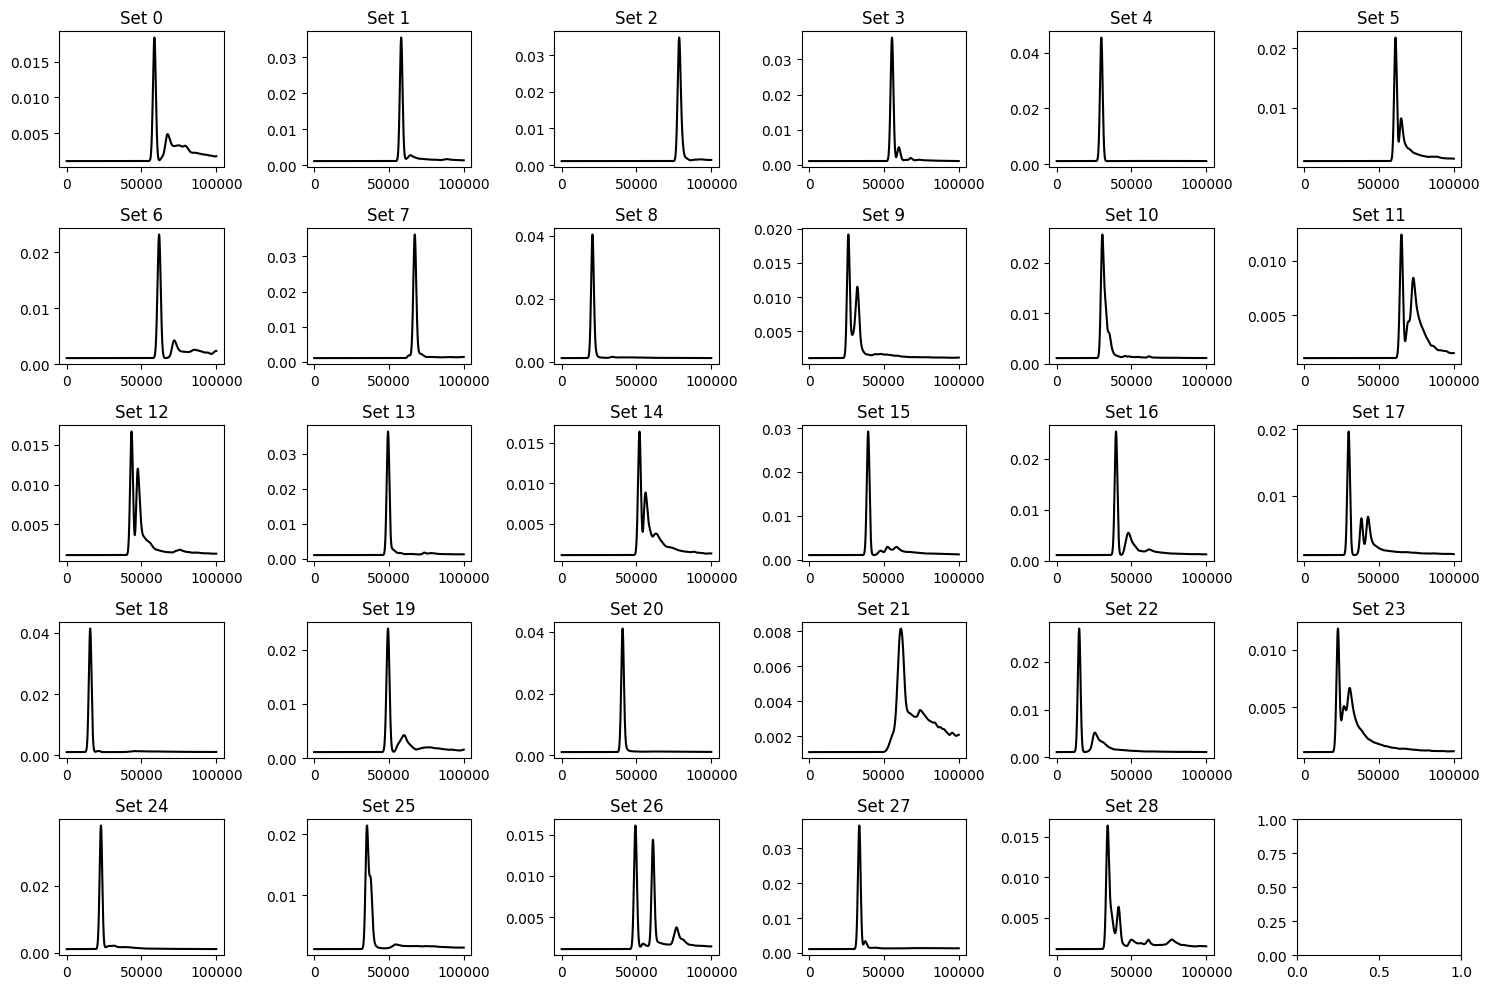

In [4]:
# Ground-truth plots of entire dataset
# TODO: replace magic #'s with constants
set_length = len(transients) if len(transients) == len(bounds) else 0
fig, axes = plt.subplots(5, 6, figsize=(15, 10))
for i in range(5):
    for j in range(6):
        set_num = (i*6)+j
        if set_num >= set_length:
            break
        axes[i,j].plot(transients[set_num, :], 'k')
        axes[i,j].title.set_text(f'Set {set_num}')
fig.tight_layout()

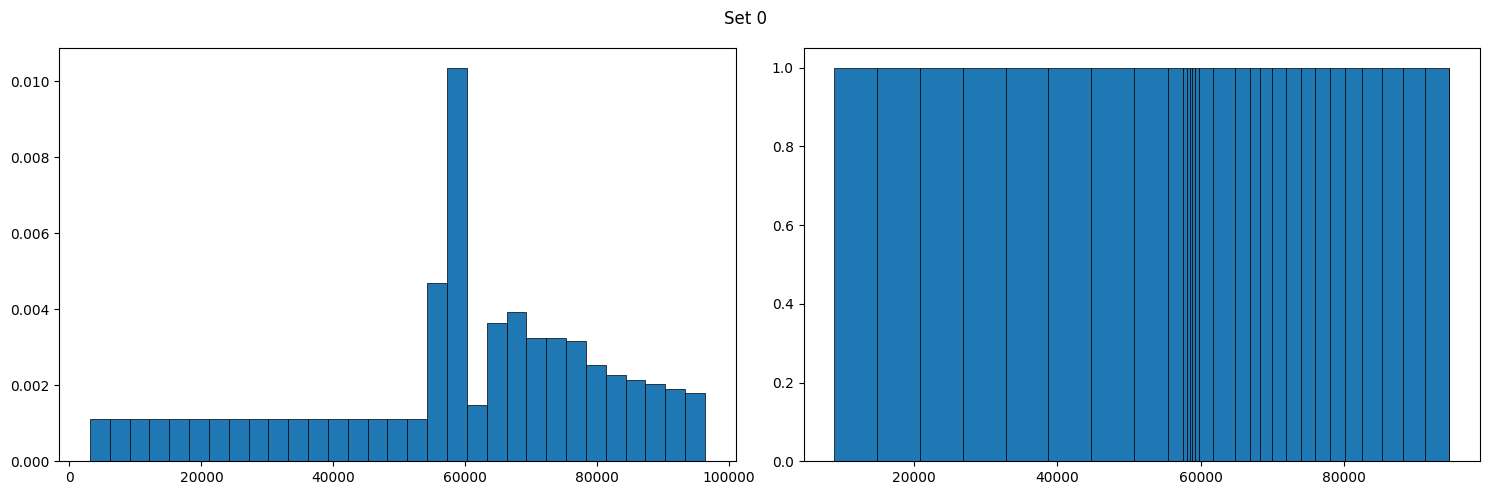

In [5]:
# Equi-width & equi-depth histograms for set chosen
ew_bds, ew_trs = convert_ew(bds.copy(), trs.copy())
ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(ew_bds, bins=31, weights=ew_trs, edgecolor='black', linewidth=0.5)
axes[1].hist(ed_bds, bins=np.append(ed_bds, np.max(ed_bds)+1), edgecolor='black', linewidth=0.5)
fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

## Tests:

# Gaussian Process (GP) Regression

Implementation, graphing, and error testing of GP regression against the ground-truth transient arrival data. To put it simply, GP regression attempts to find a best-fit function (along with it's parameters) over a range of possible functions by using a kernel function to determine the relation between each point relative to it's neighbor in the training dataset. For testing purposes, this experiment makes use of *scikit-learn's* `GaussianProcessRegressor` class in order to more easily test the model's accuracy with the ground-truth data

## Implementation:

In [6]:
# GP model gen
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic

def gaussian_model(b_set, t_set):
    lc = np.mean(np.diff(b_set))
    a = np.min(np.diff(b_set)) / np.max(np.diff(b_set))
    kernel = RationalQuadratic(length_scale=lc, alpha=a, length_scale_bounds='fixed', alpha_bounds='fixed')
    return GaussianProcessRegressor(kernel=kernel).fit(b_set.reshape(-1, 1), t_set)

## Graphs:

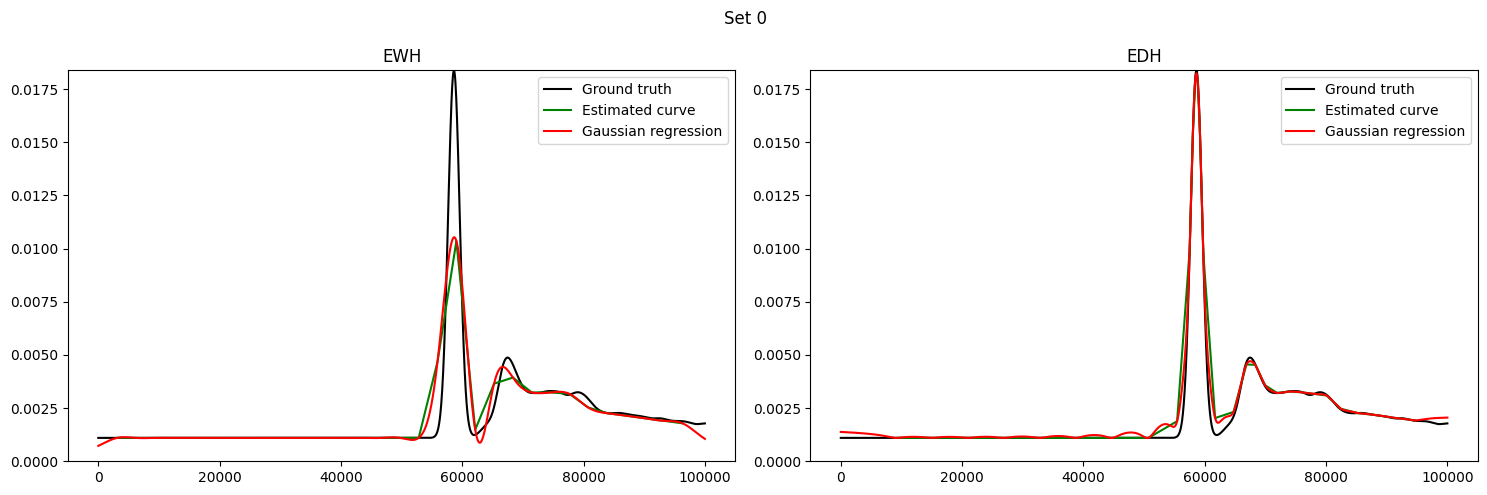

In [7]:
x_test = np.arange(0, len(trs)).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ew_bds, ew_trs = convert_ew(bds.copy(), trs.copy())
ew_mod = gaussian_model(ew_bds, ew_trs)
axes[0].set_ylim([0, np.max(trs)])
axes[0].plot(x_test, trs, 'k', label='Ground truth')
axes[0].plot(ew_bds, ew_trs, 'g', label='Estimated curve')
axes[0].plot(x_test, ew_mod.predict(x_test), 'r', label='Gaussian regression')
axes[0].legend()
axes[0].title.set_text('EWH')

ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
ed_mod = gaussian_model(ed_bds, ed_trs)
axes[1].set_ylim([0, np.max(trs)])
axes[1].plot(x_test, trs, 'k', label='Ground truth')
axes[1].plot(ed_bds, ed_trs, 'g', label='Estimated curve')
axes[1].plot(x_test, ed_mod.predict(x_test), 'r', label='Gaussian regression')
axes[1].legend()
axes[1].title.set_text('EDH')

fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

# LOWESS Regression

Implementation, graphing, and error testing of LOWESS (lowess) regression against the ground-truth transient arrival data. Lowess regression is another non-parametic regression method that involves finding a combination of linear regressions at each datapoint in the training set, with each linear regression using the distance between the current point and it's neighbors in order to determine how each neighbor point affects the weight given in the regression. This experiment makes use of *Moepy's* `Lowess` class for testing purposes

## Implementation:

In [8]:
# lowess model gen
from moepy import lowess

def lowess_model(b_set, t_set):
    lowess_model = lowess.Lowess()
    lowess_model.fit(b_set, t_set, frac=0.1, robust_iters=0)
    return lowess_model

## Graphs:

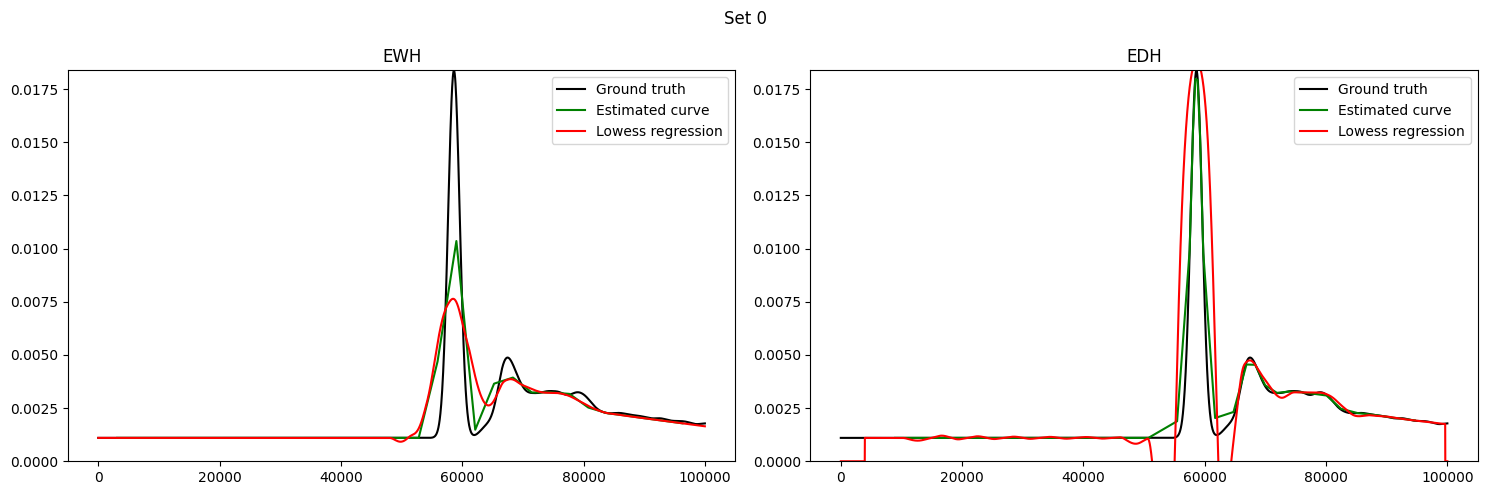

In [9]:
x_test = np.arange(0, len(trs)).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ew_bds, ew_trs = convert_ew(bds.copy(), trs.copy())
ew_mod = lowess_model(ew_bds, ew_trs)
axes[0].set_ylim([0, np.max(trs)])
axes[0].plot(x_test, trs, 'k', label='Ground truth')
axes[0].plot(ew_bds, ew_trs, 'g', label='Estimated curve')
axes[0].plot(x_test, ew_mod.predict(x_test), 'r', label='Lowess regression')
axes[0].legend()
axes[0].title.set_text('EWH')

ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
ed_mod = lowess_model(ed_bds, ed_trs)
axes[1].set_ylim([0, np.max(trs)])
axes[1].plot(x_test, trs, 'k', label='Ground truth')
axes[1].plot(ed_bds, ed_trs, 'g', label='Estimated curve')
axes[1].plot(x_test, ed_mod.predict(x_test), 'r', label='Lowess regression')
axes[1].legend()
axes[1].title.set_text('EDH')

fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

# Kernel Density Estimation (KDE)

Implementation, graphing, and error testing of Kernel Density Estimation (KDE) against the ground-truth transient arrival data. Differing from the other two methods, KDE attempts to find the PMF of the probility of photon arrivals throughout the exposure time. This pmf can then be scaled against the captured transient data in order to reproduce the reponse curve. This experiment makes use of *Scipy's* `gaussian_kde` function for testing purposes

## Implementation:

In [10]:
from scipy.stats import gaussian_kde

def kde_model(b_set, t_set):
    bw = 0.05 # multipled by standard deviation of training set
    return gaussian_kde(b_set, bw_method=bw)

## Graphs:

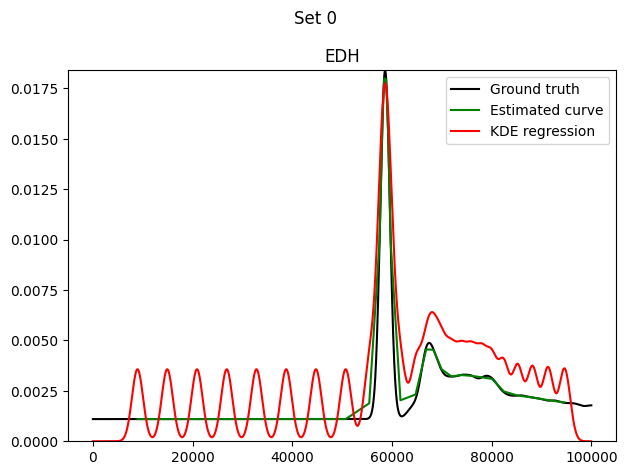

In [17]:
x_test = np.arange(0, len(trs))

fig, axes = plt.subplots()

ed_bds, ed_trs = convert_ed(bds.copy(), trs.copy())
ed_mod = kde_model(ed_bds, ed_trs)
axes.set_ylim([0, np.max(trs)])
axes.plot(x_test, trs, 'k', label='Ground truth')
axes.plot(ed_bds, ed_trs, 'g', label='Estimated curve')
axes.plot(x_test, ed_mod.evaluate(x_test)*len(ed_bds)*10, 'r', label='KDE regression')
axes.legend()
axes.title.set_text('EDH')

fig.suptitle(f'Set {SET_NUM}')
fig.tight_layout()

# References